# Importing Libraries

In [1]:
!pip3 install transformers
!pip3 install tensorflow_addons

import torch
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow_addons.optimizers import AdamW
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.9 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Preparing the Data

### Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [4]:
df = pd.read_csv("training_set_rel3.tsv",sep='\t', encoding='ISO-8859-1',
                            usecols = ['essay_id', 'essay_set', 'essay','domain1_score']).dropna(axis=1)
 
print('Rows in Data: ', len(df))
df.head()

Rows in Data:  12976


,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


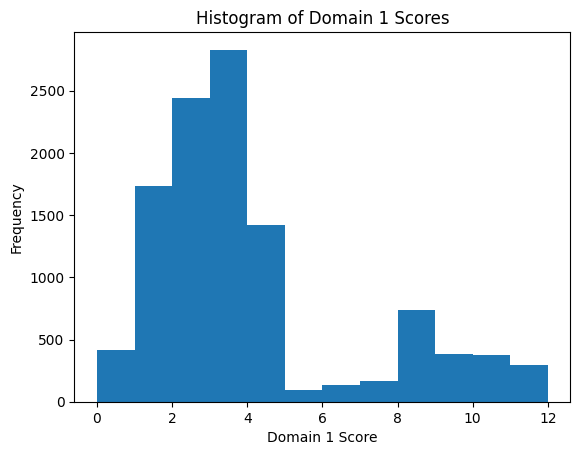

In [5]:
import matplotlib.pyplot as plt

# Extract the domain1_score column as a list
scores = df['domain1_score'].tolist()

# Plot a histogram of the scores
plt.hist(scores, bins=range(0, 13))
plt.xlabel('Domain 1 Score')
plt.ylabel('Frequency')
plt.title('Histogram of Domain 1 Scores')
plt.show()


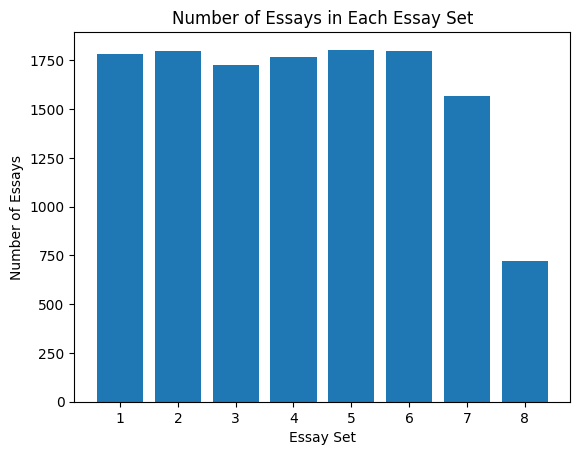

In [6]:
import matplotlib.pyplot as plt

# Count the number of essays in each essay set
essay_counts = df['essay_set'].value_counts()

# Plot a bar chart of the essay counts
plt.bar(essay_counts.index, essay_counts.values)
plt.xlabel('Essay Set')
plt.ylabel('Number of Essays')
plt.title('Number of Essays in Each Essay Set')
plt.show()


### Normalizing Data

In [7]:
# Group the essays by essay set
grouped = df.groupby('essay_set')

# Define the min-max normalization function
def normalize_scores(x):
    return (x - x.min()) / (x.max() - x.min())

# Normalize the scores in each group
normalized_scores = grouped['domain1_score'].transform(normalize_scores)

# Replace the 'domain1_score' column with the normalized scores
df['domain1_score'] = normalized_scores

df.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",0.6
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.7
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",0.5
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.8
4,5,1,"Dear @LOCATION1, I know having computers has a...",0.6


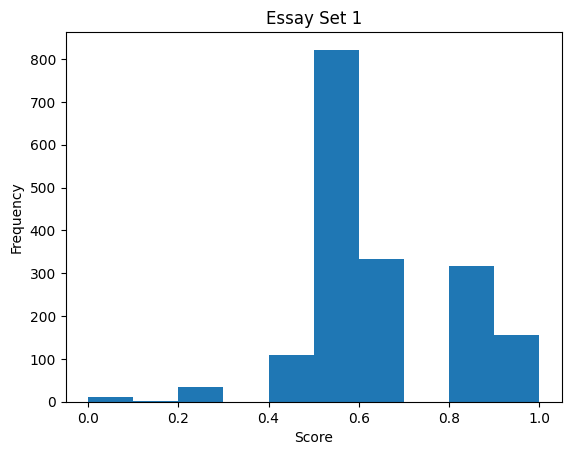

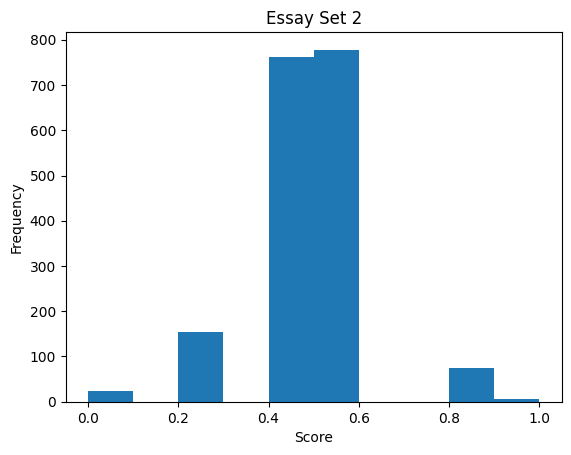

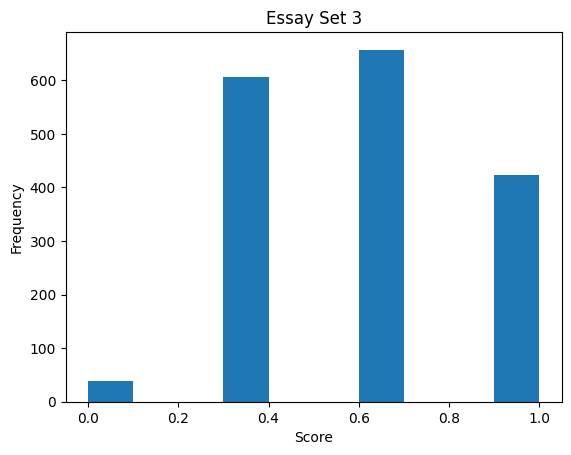

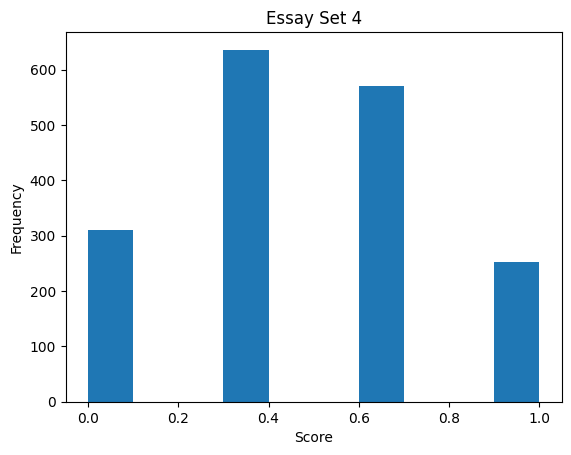

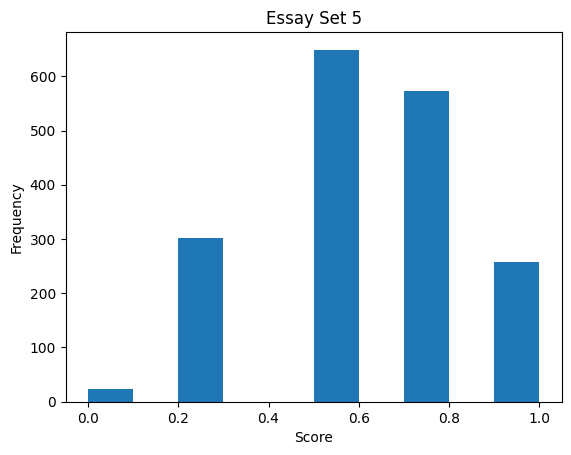

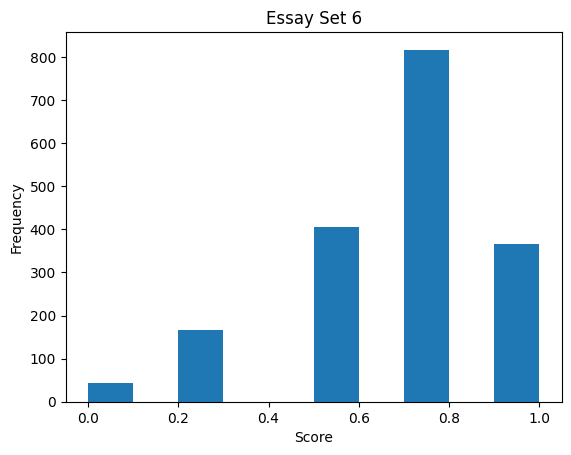

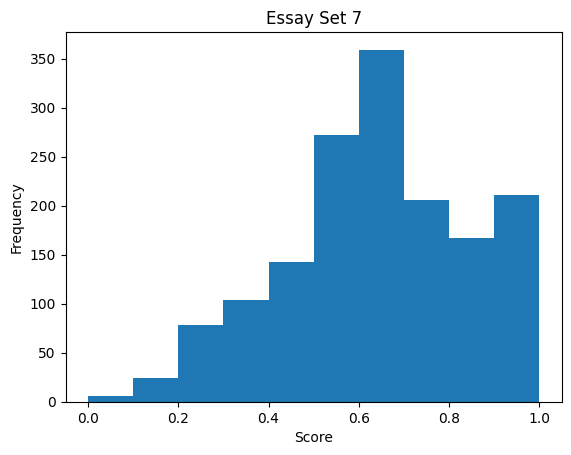

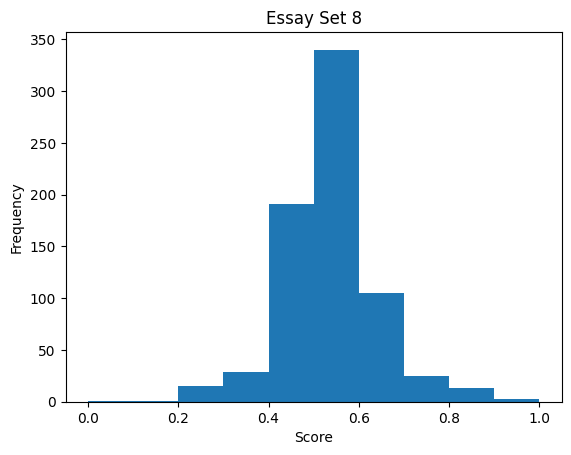

In [8]:
#plot normalized scores by essay set
grouped = df.groupby('essay_set')

# Plot a histogram of scores in each group
for name, group in grouped:
    plt.hist(group['domain1_score'], bins=10)
    plt.title('Essay Set {}'.format(name))
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

### Transforming to Categorical 

In [9]:
# Define a function to transform the scores into 2 classes
def transform_scores(x):
    if x > 0.5:
        return 1
    else:
        return 0

# Apply the transformation function to the 'domain1_score' column
df['domain1_score'] = df['domain1_score'].apply(transform_scores)

df.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",1
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",1
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",0
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",1
4,5,1,"Dear @LOCATION1, I know having computers has a...",1


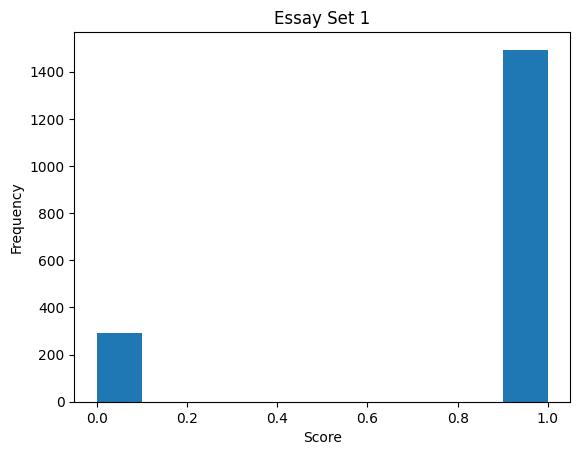

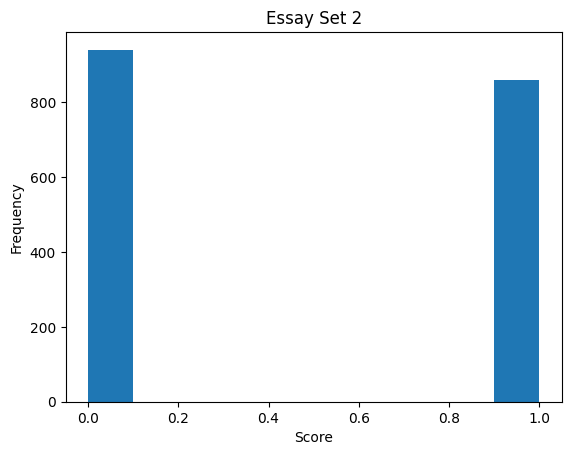

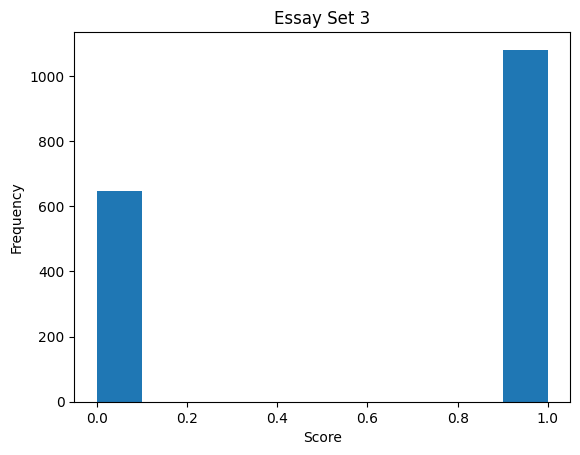

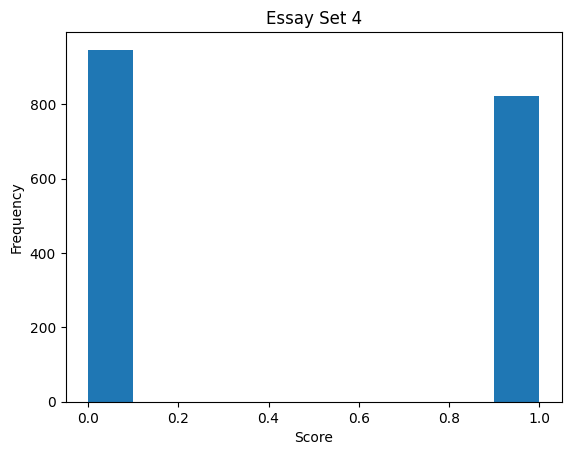

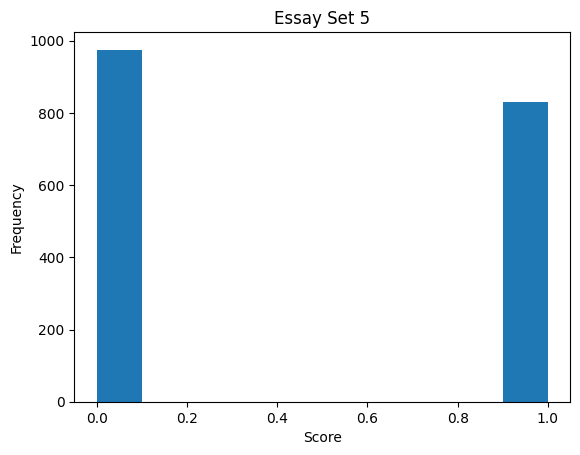

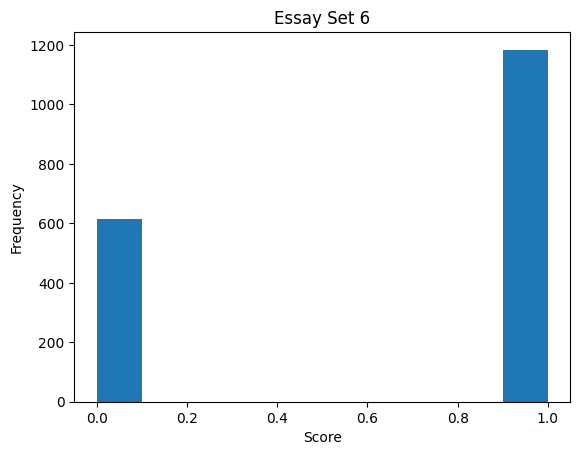

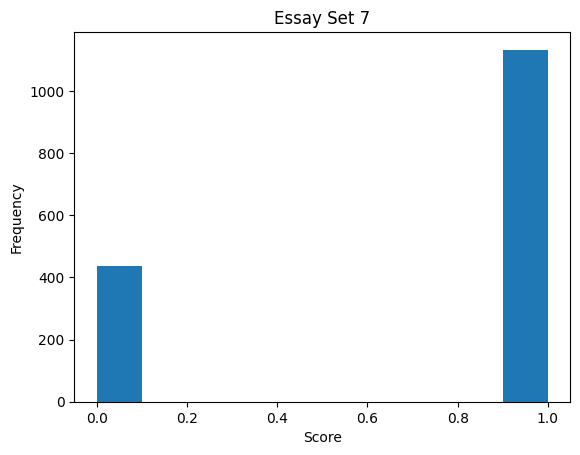

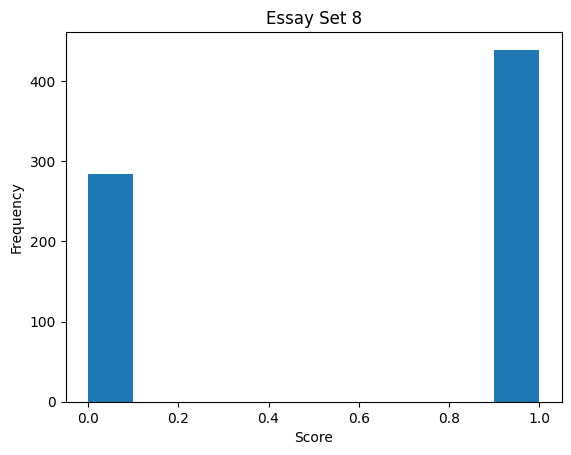

In [10]:
#Plot Binary Scores by Essay Set

grouped = df.groupby('essay_set')

# Plot a histogram of scores in each group
for name, group in grouped:
    plt.hist(group['domain1_score'], bins=10)
    plt.title('Essay Set {}'.format(name))
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

# Model

### Defining the Model

In [11]:
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = False

# Define the input shape of the model
max_len = 128
input_ids = Input(shape=(max_len,), dtype=tf.int32)

# Use the BERT model to create word embeddings
bert_output = bert_model(input_ids)[0]

# Use a CNN to create sentence embeddings
conv1 = Conv1D(filters=128, kernel_size=5, activation='relu')(bert_output)
pool1 = MaxPooling1D(pool_size=5)(conv1)
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=5)(conv2)

# Use a Bi-LSTM to create essay embeddings
lstm = Bidirectional(LSTM(128))(pool2)
dropout = Dropout(0.5)(lstm)

# Add a fully connected layer for classification
dense = Dense(64, activation='relu')(dropout)
output = Dense(2, activation='softmax')(dense)

# Define the model
model = tf.keras.Model(inputs=input_ids, outputs=output)

# Define the optimizer and compile the model
optimizer = AdamW(learning_rate=1e-5, weight_decay=1e-2)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Train Test Splits

In [12]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Print the number of essays in each set
print("Number of essays in the training set: ", len(train_df))
print("Number of essays in the testing set: ", len(test_df))


# Tokenize the essays and create word embeddings
tokenized = train_df['essay'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_len, truncation=True))
padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized, maxlen=max_len, dtype='long', padding='post', truncating='post')
X = tf.convert_to_tensor(padded)
y = train_df['domain1_score'].to_numpy()



Number of essays in the training set:  9732
Number of essays in the testing set:  3244


### Training

In [13]:
# Train the model
model.fit(X, y, batch_size=32, epochs=5)

Epoch 1/5
305/305 [==============================] - 113s 297ms/step - loss: 0.6980 - accuracy: 0.5896
Epoch 2/5
305/305 [==============================] - 92s 303ms/step - loss: 0.6930 - accuracy: 0.6054
Epoch 3/5
305/305 [==============================] - 92s 303ms/step - loss: 0.6930 - accuracy: 0.6054
Epoch 4/5
305/305 [==============================] - 93s 303ms/step - loss: 0.6930 - accuracy: 0.6054
Epoch 5/5
305/305 [==============================] - 93s 304ms/step - loss: 0.6930 - accuracy: 0.6054


### Saving Trained Model

In [ ]:
import os
from tensorflow.keras.models import load_model

#Saving Model 
# Create the folder to store the model
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Save the model
model.save('saved_models/my_model_final_5EpochNonPCA')

# Load the model
#loaded_model = load_model('saved_models/my_model_final_5EpochNonPCA')


# Evaluation

102/102 [==============================] - 39s 293ms/step


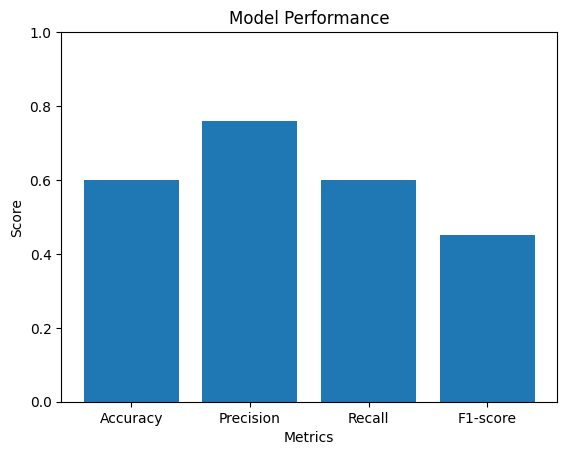

In [14]:
# Evaluate the model using accuracy, precision, recall, and F1-score
test_tokenized = test_df['essay'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_len, truncation=True))
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_tokenized, maxlen=max_len, dtype='long', padding='post', truncating='post')
X_test = tf.convert_to_tensor(test_padded)
y_test = test_df['domain1_score'].to_numpy()

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=1)  # Added zero_division parameter
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

import matplotlib.pyplot as plt

# Define the metrics and their values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
values = [accuracy, precision, recall, f1]

# Create a bar chart
plt.bar(metrics, values)
plt.ylim(0, 1)  # Set y-axis range to [0, 1]

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance')

# Display the chart
plt.show()



In [15]:
print('Accuracy = ', accuracy)
print('Precision = ', precision)
print('Recall = ', recall)
print('F1 = ', f1)

Accuracy =  0.6011097410604193
Precision =  0.7602231797373049
Recall =  0.6011097410604193
F1 =  0.45135309783127353
